OK so for ease of use I dumped astro_sherpa.py into here so you guys don't have worry about importing it

In [1]:
import inspect
import numpy as np
import operator as op
from collections import defaultdict, OrderedDict
from pyparsing import nestedExpr
from sherpa.stats import Stat, LeastSq,Chi2
from sherpa.fit import Fit
from sherpa.optmethods import OptMethod, LevMar
from sherpa.estmethods import EstMethod, Covariance
from sherpa.data import Data1D, Data1DInt, Data2D, Data2DInt, DataSimulFit
from sherpa.models import UserModel, Parameter, SimulFitModel
from astropy.modeling.fitting import Fitter

In [2]:
# need to check aviable operators
OPERATORS = OrderedDict([
    ('^', op.pow),
    ('**', op.pow),
    ('*', op.mul),
    ('/', op.div),
    ('//', op.floordiv),
    ('+', op.add),
    ('-', op.sub)
])


def _expression_to_list(expr):
    """
    This takes an expression i.e '[0]+[1]*([2]+[3])' and returns the list ['[0]+[1]*',['[2]+[3]']]

    Parameters
    ----------
        expr: parseString
            this expression you wish to pars
        returns: list
            a list of parsed expression
    """
    return nestedExpr().parseString("(" + expr + ")").asList()[0]


def _parse_expression(exp_list, models):
    """
    This takes an expression list and a list of models it coverts the models
    then constucts a compound model based on the expression list.

    Parameters:
        exp_list: list
            a list expression like the output of _expression_to_list
        models: list
            a list of astropy models which are to be coverted
    """
    to_return = []
    if isinstance(exp_list, list):
        for part in exp_list:
            if isinstance(part, list):
                to_return.extend(_parse_expression(part, models))
            else:
                if part in OPERATORS.keys():
                    to_return.append(part)
                else:
                    to_return.append(models[part.replace("[", "").replace("]", "")])

        for txtop, oper in OPERATORS.items():
            while txtop in to_return:
                opindex = to_return.index(txtop)
                to_return[opindex - 1] = oper(to_return[opindex - 1], to_return[opindex + 1])
                to_return.pop(opindex + 1)
                to_return.pop(opindex)
        return to_return
    else:
        return exp_list


def _astropy_to_sherpa_model(model, deconstruct=False):
    """
    This takes astropy models and converts them to sherpa models.
    If deconstruct is true then the submodels are converted then recombined.

    Parameters
    ----------
        model : `~astropy.modeling.FittableModel`
            the model you wish to convert
        diconstruct: bool
            if True each submodel is converted then re-assembled based on the
            model._format_expression()
    """

    def _convert_to_sherpa_model(model):
        '''
        Converts the model using sherpa's usermodel suppling the parameter detail to sherpa
        then using a decorator to allow the call method to act like the calc method
        '''
        def _calc2call(func):
            '''This decorator makes call and eval work together.'''
            def _converter(inp, *x):
                if func.n_inputs==1:
                    #startp = func._parameters[:]
                    #func._parameters = np.array(inp)
                    retvals = func.evaluate(x,*inp)[0]
                    #func._parameters = startp
                else:
                    retvals = func.evaluate(x[0],x[1],*inp)[0]
                return retvals
            return _converter

        pars = []
        for pname in model.param_names:
            param = model.__getattribute__(pname)
            vals = [param.name, param.value, param.min, param.max, param.min,
                    param.max, None, param.fixed, False]
            attrnames = ["name", "val", "min", "max", "hard_min", "hard_max",
                         "units", "frozen", "alwaysfrozen"]
            if model.name is None:
                model._name = ""
            pars.append(Parameter(modelname="wrap_" + model.name, **
                                  dict([(atr, val) for atr, val in zip(attrnames, vals) if val is not None])))

        smodel = UserModel(model.name, pars)
        smodel.calc = _calc2call(model)

        return smodel

    if deconstruct:
        models = [_convert_to_sherpa_model(m) for m in model.submodels]
        expression = model._format_expression()

        if isinstance(models, list) or isinstance(models, tuple):
            models = {str(num): mod for num, mod in enumerate(models)}

            expression_list = _expression_to_list(expression)
            return [_parse_expression(elist, models)[0] for elist in expression_list]
        else:
            expression_list = _expression_to_list(expression)
            return _parse_expression(expression_list, models)[0]
    else:
        return _convert_to_sherpa_model(model)


def _make_datasets(n_dim, x, y, z=None, xerr=None, yerr=None, zerr=None):
    '''
    Parameters
        ----------
        n_dim: int
            Used to veirfy required number of dimentions.
        x : array
            input coordinates
        y : array
            input coordinates
        z : array (optional)
            input coordinates
        xerr : array (optional)
            an array of errors in x
        yerr : array (optional)
            an array of errors in y
        zerr : array (optional)
            an array of errors in z

    returns:
        _data: a sherpa dataset (if mutiple data sets are given a DataSimulFit will be returned)

    '''

    def _iterTranspose(array):  # this takes each element from the dstack and transposes back into columns
        for x in array:
            yield x.T

    x = np.asarray(x)
    y = np.asarray(y)

    if (z is None and n_dim > 1) or (z is not None and n_dim == 1):
        raise Exception("Model and data dimentions don't match")

    if z is None:
        assert x.shape == y.shape, "shape of x and y don't match"
    else:
        z = np.asarray(z)
        assert x.shape == y.shape == z.shape, "shapes x,y and z don't match"

    if yerr is not None:
        yerr = np.array(yerr)
        assert y.shape == yerr.shape, "y's and yerr's shapes do not match"

    if xerr is not None:
        xerr = np.array(xerr)
        assert x.shape == xerr.shape, "x's and xerr's shapes do not match"

    if z is not None and zerr is not None:
        zerr = np.array(zerr)
        assert z.shape == zerr.shape, "z's and zerr's shapes do not match"

    _data = []
    '''
    So the generall method is to dstack(and transpose each row) so
        [x1,x2,x3],[y1,y2,y3],[z1,z2,z3],...
    becomes
        [x1,y1,,z1],[x2,y2,,z2],[x3,y3,,z3],...
        the and put it into a data set! this assumes that all columns are set for all datasets!
        athough a none can be put in place of missing columns
    '''
    if z is None:
        if xerr is None:
            if yerr is None:
                dstack = np.dstack((x, y))
                # if dstack.shape[0] == 1:
                #    dstack = dstack[0]
                for xx, yy in _iterTranspose(dstack):
                    assert xx.shape == yy.shape, "shape of x and y don't match"
                    _data.append(Data1D("wrapped_data", x=xx, y=yy))
            else:
                dstack = np.dstack((x, y, yerr))
                # if dstack.shape[0] == 1:
                #    dstack = dstack[0]

                for xx, yy, yyerr in _iterTranspose(dstack):
                    assert xx.shape == yy.shape == yyerr.shape, "shape of x,y and yerr don't match"
                    _data.append(Data1D("wrapped_data", x=xx, y=yy, staterror=yyerr))
        else:
            if yerr is None:
                dstack = np.dstack((x, y, xerr))
                # if dstack.shape[0] == 1:
                #    dstack = dstack[0]
                for xx, yy, xxerr in _iterTranspose(dstack):
                    assert xx.shape == yy.shape == xxerr.shape, "shape of x, y and xerr don't match"
                    _data.append(Data1DInt("wrapped_data", xlo=xx - xxerr, xhi=xx + xxerr, y=yy))
            else:
                dstack = np.dstack((x, y, xerr, yerr))
                # if dstack.shape[0] == 1:
                #    dstack = dstack[0]
                for xx, yy, xxerr, yyerr in _iterTranspose(dstack):
                    assert xx.shape == yy.shape == xxerr.shape == yyerr.shape, "shape of x, y, xerr and yerr don't match"
                    _data.append(Data1DInt("wrapped_data", xlo=xx - xxerr, xhi=xx + xxerr, y=yy, staterror=yyerr))

    else:
        if xerr is None and yerr is None:
            if zerr is None:
                dstack = np.dstack((x, y, z))
                # if dstack.shape[0] == 1:
                #    dstack = dstack[0]
                for xx, yy, zz in _iterTranspose(dstack):
                    assert xx.shape == yy.shape == zz.shape, "shape of x, y, and z don't match"
                    _data.append(Data2D("wrapped_data", x0=xx, x1=yy, y=zz))
            else:
                dstack = np.dstack((x, y, z, zerr))
                # if dstack.shape[0] == 1:
                #   dstack = dstack[0]
                for xx, yy, zz, zzerr in _iterTranspose(dstack):
                    assert xx.shape == yy.shape == zz.shape == zzerr.shape, "shape of x, y, z and zerr don't match"
                    _data.append(Data2D("wrapped_data", x0=xx, x1=yy, y=zz, staterror=zzerr))
        elif xerr is not None and yerr is not None:
            if zerr is None:
                dstack = np.dstack((x, y, z, xerr, yerr))
                # if dstack.shape[0] == 1:
                #    dstack = dstack[0]
                for xx, yy, zz, xxerr, yyerr in _iterTranspose(dstack):
                    assert xx.shape == yy.shape == xxerr.shape == yyerr.shape, "shape of x, y, z, xerr and yerr don't match"
                    _data.append(Data2DInt("wrapped_data", x0lo=x - xerr, x0hi=x + xerr, x1lo=y - yerr, x1hi=y + yerr))
            else:
                dstack = np.dstack((x, y, z, xerr, yerr, zerr))
                # if dstack.shape[0] == 1:
                #    dstack = dstack[0]
                for xx, yy, zz, xxerr, yyerr, zzerr in _iterTranspose(dstack):
                    assert xx.shape == yy.shape == zz.shape == zzerr.shape == xxerr.shape == yyerr.shape, "shape of x, y, z, xerr, yerr and zerr don't match"
                    _data.append(Data2DInt("wrapped_data", x0lo=x - xerr, x0hi=x + xerr, x1lo=y - yerr, x1hi=y + yerr, staterror=zerr))
        else:
            raise Exception("Set xerr and yerr, or set neither!")

    _ndata = len(_data)
    if _ndata > 1:
        _data = DataSimulFit("wrapped_data", _data)
    else:
        _data = _data[0]
    return _data


class SherpaFitter(Fitter):
    """
    Sherpa Fitter for astropy models. Yay :)

    Parameters
        ----------
        optimizer : (callable)
                    A sherpa optimizer method.
        statistic : (callable)
                    A sherpa statistic function.
        estmethod : (callable)
                    A shepra error estimation method.
    """

    def __init__(self, optimizer=LevMar, statistic=LeastSq, estmethod=Covariance):
        '''
        check the types of optimizer, statistic and estmethod are sherpa based classes
         so we can use them
        '''
        if inspect.isclass(optimizer) and not issubclass(optimizer, OptMethod):
            raise TypeError("optimizer must be sherpa OptMethod class or isinstance")
        elif inspect.isfunction(optimizer) and not issubclass(optimizer.__class__, OptMethod):
            raise TypeError("optimizer must be sherpa OptMethod class or isinstance")

        if inspect.isclass(statistic) and not issubclass(statistic, Stat):
            raise TypeError("statistic must be sherpa Stat class or isinstance")
        elif inspect.isfunction(statistic) and not issubclass(statistic.__class__, Stat):
            raise TypeError("statistic must be sherpa Stat class or isinstance")

        if inspect.isclass(estmethod) and not issubclass(estmethod, EstMethod):
            raise TypeError("estmethod must be sherpa EstMethod class or isinstance")
        elif inspect.isfunction(estmethod) and not issubclass(estmethod.__class__, EstMethod):
            raise TypeError("estmethod must be sherpa EstMethod class or isinstance")

        super(SherpaFitter, self).__init__(optimizer=optimizer, statistic=statistic)
        if inspect.isclass(estmethod):
            self._est_method = estmethod()
        else:
            self._est_method = estmethod

        self.fit_info = {}
        self._fitter = None  # a handle for sherpa fit function
        self._fitmodel = None  # a handle for sherpa fit model
        self._data = None  # a handle for sherpa dataset

    def __call__(self, model, x, y, z=None, xerr=None, yerr=None, zerr=None, **kwargs):
        """
        Fit the astropy model with a the sherpa fit routines.

        Parameters
        ----------
        model : `~astropy.modeling.FittableModel`
            model to fit to x, y, z
        x : array
            input coordinates
        y : array
            input coordinates
        z : array (optional)
            input coordinates
        xerr : array (optional)
            an array of errors in x
        yerr : array (optional)
            an array of errors in y
        zerr : array (optional)
            an array of errors in z
        **kwargs:
            keyword arguments will be passed on to sherpa fit routine

        Returns
        -------
        model_copy : `~astropy.modeling.FittableModel`
            a copy of the input model with parameters set by the fitter
        """

        self._data = _make_datasets(model.n_inputs, x, y, z, xerr, yerr, zerr)

        if isinstance(self._data, DataSimulFit):
            _ndata = len(self._data.datasets)
            if len(model) == 1:
                self._fitmodel = SimulFitModel("wrapped_fit_model", [_astropy_to_sherpa_model(model) for _ in xrange(_ndata)])
                # Copy the model so each data set has the same model!
            else:
                raise Exception("Don't know how to handle multiple modesl")
        else:
            self._fitmodel = _astropy_to_sherpa_model(model)

        self._fitter = Fit(self._data, self._fitmodel, self._stat_method, self._opt_method, self._est_method, **kwargs)
        self.fit_info = self._fitter.fit()

        newparam_vals = defaultdict(list)
        for pname, pval in zip(self.fit_info.parnames, self.fit_info.parvals):
            newparam_vals[pname].append(pval)

        _start = 0
        _parameters = []

        model_copy = model.copy()  # stops old model being updated ... pointers!
        for pname in np.unique(self.fit_info.parnames):
            pval = newparam_vals[pname]
            model_copy._param_metrics[pname.split(".")[-1]]['shape'] = (len(pval),)
            model_copy._param_metrics[pname.split(".")[-1]]['slice'] = slice(_start, _start + len(pval))
            _start += len(pval)

            _parameters.extend(pval)

        model_copy._parameters = np.array(_parameters)
        model_copy._n_models = len(pval)
        return model_copy

    def est_errors(self, sigma=None, maxiters=None, methoddict=None, parlist=None):
        '''
        Use sherpa error estimators based on the last fit.

        Parameters:
            sigma: float
                this will be set as the confidance interval for which the errors are found too.
            maxiters: int
                the maximum number of iterations the error estimator will run before giving up.
            methoddict: dict
                !not quite sure couldn't figure this one out yet!
            parlist: list
                a list of parameters to find the confidance interval of if none are provided all free
                parameters will be estimated.

        '''
        if self._fitter is None:
            ValueError("Must complete a valid fit before errors can be calculated")

        if sigma is not None:
            self._fitter.estmethod.config['sigma'] = sigma
        if maxiters is not None:
            self._fitter.estmethod.config['maxiters'] = maxiters
        # print self._fitter.estmethod.config
        return self._fitter.est_errors(methoddict=methoddict, parlist=parlist)


Lets make an instance of the fitter which I can use for error estimates

In [3]:
sfit = SherpaFitter(statistic=Chi2())

In [4]:
import numpy as np
from astropy.modeling.models import Gaussian1D

We need some data to fit!

In [5]:
model = (Gaussian1D(amplitude=1.2, mean=0.9, stddev=0.5) +
         Gaussian1D(amplitude=2.0, mean=-0.9, stddev=0.75))
err = 0.1
x = np.arange(-3, 3, .1)
y = []
yerrs=[]

y.append(model(x)+err*np.random.uniform(-1,1,size=len(x)))
yerrs.append(err * np.random.uniform(size=len(x)))

model.amplitude_0 = 1.0
model.mean_1 = -1
y.append(model(x)+err*np.random.uniform(-1,1,size=len(x)))
yerrs.append(err * np.random.uniform(size=len(x)))


model.amplitude_0 = 0.6
model.mean_1 = -0.4
y.append(model(x)+err*np.random.uniform(-1,1,size=len(x)))
yerrs.append(err * np.random.uniform(size=len(x)))


model.amplitude_1 = 0.2
model.mean_1 = -2
y.append(model(x)+err*np.random.uniform(-1,1,size=len(x)))
yerrs.append(err * np.random.uniform(size=len(x)))


model.amplitude_0 = 2
model.mean_0 = 1
model.stddev_0 = 0.2
model.amplitude_1 = 1.5
model.mean_1 = -0.4
model.stddev_1 = 0.35 

In [6]:
%pylab inline
from itertools import cycle

Populating the interactive namespace from numpy and matplotlib


So we lets fit each data set individually and plot it over the data to check it looks orite!
Then fit them all together and return a model with multiple value for each parameter corisponding to each.
I actually decided this isn't the best way to return the data it's fine if the it's just one model but in general it makes no sense so now it will return a list of models which have been updated - haven't changed that in SherpaFitter yet.

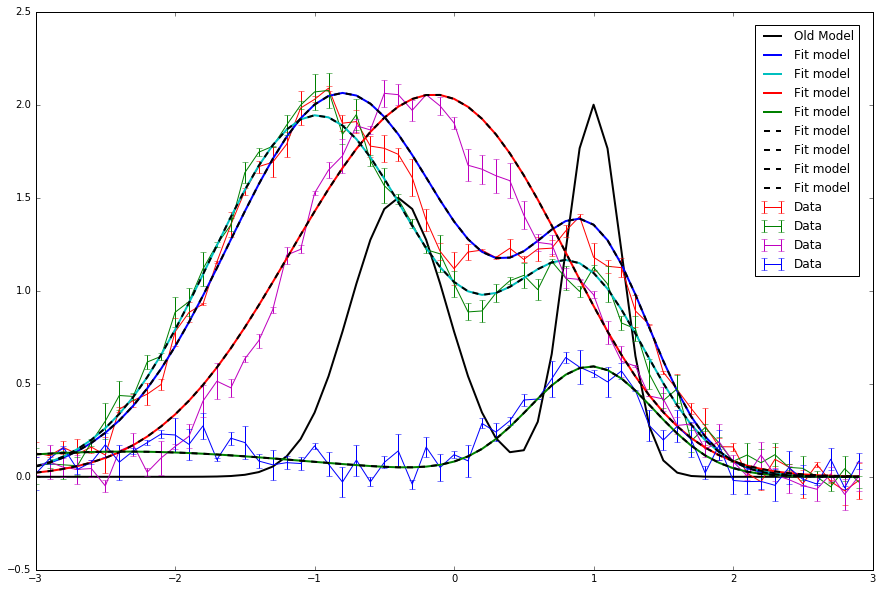

In [7]:
plt.rcParams['figure.figsize']=(15,10)
plt.ion()
plt.plot(x, model(x), lw=2, label="Old Model", c="k")
colcycle = cycle(['r', 'b', 'g', 'c', 'm'])
for yy,yee in zip(y,yerrs):
    fitmodel = sfit(model, x, yy,yerr=yee) # fitting is here!
    plt.errorbar(x, yy, label="Data", c=colcycle.next(),yerr=yee)
    plt.plot(x, fitmodel(x),lw=2, label="Fit model", c=colcycle.next())
plt.legend()


xx = np.vstack([x for _ in xrange(len(y))])
fitmodel = sfit(model, xx, y,yerr=yerrs)
plt.plot(np.array(xx).T, fitmodel(x).T, lw=2, ls="--", label="Fit model", c='k')
plt.legend(loc=(0.86,0.527))


Fits are useless without error estimates so lets do that! And for the fun of it let's specify two confidance intervals.

In [8]:
err_res2=sfit.est_errors()
err_res=sfit.est_errors(sigma=10)

The next few cels are just me minipulating the extimates do we have models which represent the max and min models just for visulation proposes

In [9]:
err_vals=defaultdict(list)
for pname, minmax in zip([pname.split(".")[-1] for pname in err_res.parnames], zip(err_res.parmins,err_res.parmaxes)):
    err_vals[pname].append(minmax)
    
ppnn=[]
ppmm=[]

for sss in fitmodel._param_metrics:
    ppnn.append([nn for nn, mm in err_vals[sss]])
    ppmm.append([mm for nn, mm in err_vals[sss]])

In [10]:
fitmodmins=fitmodel.copy()
fitmodmaxs=fitmodel.copy()

#print np.vstack(zip(fitmodmins._parameters,fitmodmaxs._parameters))
fitmodmins._parameters+=10*np.hstack(ppnn)
fitmodmaxs._parameters+=10*np.hstack(ppmm)
#print np.vstack(zip(fitmodmins._parameters,fitmodmaxs._parameters))


So lets print the value and the confidance intervals -bit of a value dump.
Then plot the fits and the min/max models for the 10 sigma case

Value   (min1sig min10sig),(max1sig max10sig)
1.170951.2 (-1e-02 -1e-01) (1e-02 1e-01)
0.986450.2 (-7e-03 -7e-02) (7e-03 7e-02)
0.434545.2 (-7e-03 -7e-02) (7e-03 7e-02)
2.063691.2 (-9e-03 -9e-02) (9e-03 9e-02)
-0.797282.2 (-7e-03 -7e-02) (7e-03 7e-02)
0.818203.2 (-6e-03 -6e-02) (6e-03 6e-02)
1.062381.2 (-9e-03 -9e-02) (9e-03 9e-02)
0.885198.2 (-9e-03 -9e-02) (9e-03 9e-02)
0.496795.2 (-5e-03 -5e-02) (5e-03 5e-02)
1.943300.2 (-7e-03 -7e-02) (7e-03 7e-02)
-0.985956.2 (-5e-03 -5e-02) (5e-03 5e-02)
0.756001.2 (-6e-03 -6e-02) (6e-03 6e-02)
0.702180.2 (-6e-02 -6e-01) (6e-02 6e-01)
0.428659.2 (-3e-02 -3e-01) (3e-02 3e-01)
0.687919.2 (-1e-02 -1e-01) (1e-02 1e-01)
1.652052.2 (-5e-02 -5e-01) (5e-02 5e-01)
-0.441051.2 (-2e-02 -2e-01) (2e-02 2e-01)
0.871626.2 (-6e-03 -6e-02) (6e-03 6e-02)
0.588131.2 (-9e-03 -9e-02) (9e-03 9e-02)
0.984548.2 (-3e-03 -3e-02) (3e-03 3e-02)
0.449823.2 (-1e-02 -1e-01) (1e-02 1e-01)
0.135464.2 (-5e-03 -5e-02) (5e-03 5e-02)
-2.359406.2 (-1e-01 -1e+00) (1e-01 1e+00)
-1.3334

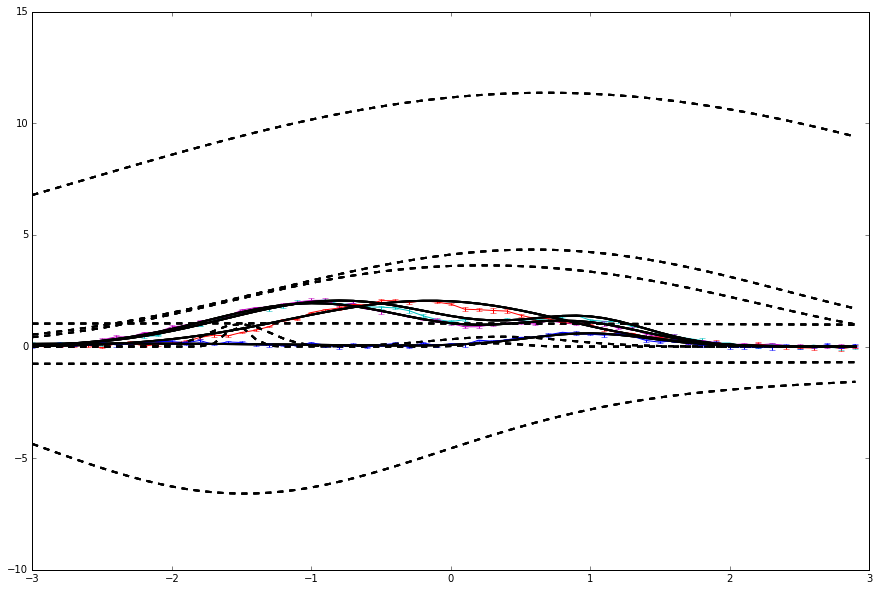

In [11]:
for x,yy,yee in zip(xx,y,yerrs):
    plt.errorbar(x, yy, label="Data", c=colcycle.next(),yerr=yee)
    plt.plot(np.array(xx).T, fitmodel(x).T, lw=2, label="Fit model", c='k')
    plt.plot(np.array(xx).T, fitmodmins(x).T, lw=2, ls="--", label="Min model", c='k')
    plt.plot(np.array(xx).T, fitmodmaxs(x).T, lw=2, ls="--", label="Max model", c='k')

print "Value   (min1sig min10sig),(max1sig max10sig)"
for (p1,l1,h1),(p2,l2,h2) in zip(zip(err_res2.parvals,err_res2.parmins,err_res2.parmaxes),zip(err_res.parvals,err_res.parmins,err_res.parmaxes)):
    print "%f.2 (%.0e %.0e) (%.0e %.0e)" % (p1,l1,l2,h1,h2)